# Imports
Before we get started, we need to import the modules needed in order to load/process the images along with the modules to extract and cluster our feature vectors.

In [34]:
from tensorflow import keras
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# clustering evaluation metrics
from sklearn.metrics.cluster import completeness_score, homogeneity_score, v_measure_score, adjusted_mutual_info_score

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from spek_gnn_clustering import GnnClustering

# Loading the data
Now that the data is downloaded on your computer, we want python to point to the location where the images are located. This way instead of loading a whole file path, we can simply just use the name of the file.

In [2]:
path = os.path.join(os.getcwd(), 'flower_dataset', 'flower_images', 'flower_images')
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

# Data Preprocessing

## Data Loading

This is where we put the load_img() and preprocess_input() methods to use. When loading the images we are going to set the target size to (224, 224) because the VGG model expects the images it receives to be 224x224 NumPy arrays.

In [3]:
# load the image as a 224x224 array
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print('Shape of an image: {}'.format(img.shape))

Shape of an image: (224, 224, 3)


## Image Reshaping

Currently, our array has only 3 dimensions (rows, columns, channels) and the model operates in batches of samples. So we need to expand our array to add the dimension that will let the model know how many images we are giving it (num_of_samples, rows, columns, channels).

In [4]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


The last step is to pass the reshaped array to the preprocess_input method and our image is ready to be loaded into the model.

In [5]:
x = preprocess_input(reshaped_img)

# The Model
Now we can load the VGG model and remove the output layer manually. This means that the new final layer is a fully-connected layer with 4,096 output nodes. This vector of 4,096 numbers is the feature vector that we will use to cluster the images.

In [6]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

2022-01-25 16:06:32.531462: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now that the final layer is removed, we can pass our image through the predict method to get our feature vector.

In [7]:
data = {}
p = os.path.join(os.getcwd(),'Model Development', 'flower_features.pkl')

# lop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)


# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

In [ ]:

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

In [ ]:
# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

In [71]:
df['label']

0      0
1      0
2      2
3      0
4      0
      ..
205    6
206    0
207    4
208    6
209    1
Name: label, Length: 210, dtype: int64

# Dimensionality Reduction (PCA)

Since our feature vector has over 4,000 dimensions, your computer will thank you if you reduce the number of dimensions from 4,000 to a much smaller number. We can't simply just shorten the list by slicing it or using some subset of it because we will lose information. If only there was a way to reduce the dimensionality while keeping as much information as possible.
Enter the realm of principle component analysis.
I'm not going to waste time explaining what PCA is because there are already tons of articles explaining it, which I’ll link here.
Simply put, if you are working with data and have a lot of variables to consider (in our case 4096), PCA allows you to reduce the number of variables while preserving as much information from the original set as possible.
The number of dimensions to reduce down to is up to you and I'm sure there's a method for finding the best number of components to use, but for this case, I just chose 100 as an arbitrary number.

In [8]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# Clustering

## k-means Clustering

This algorithm will allow us to group our feature vectors into k clusters. Each cluster should contain images that are visually similar. In this case, we know there are 10 different species of flowers so we can have k = 10.

In [72]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)
kmeans.labels_

array([4, 2, 2, 2, 1, 0, 9, 2, 4, 4, 8, 5, 6, 5, 2, 0, 7, 0, 6, 4, 4, 1,
       7, 9, 5, 7, 6, 4, 0, 6, 4, 9, 1, 6, 1, 4, 4, 1, 6, 2, 6, 2, 0, 6,
       4, 3, 1, 4, 3, 1, 6, 5, 3, 2, 4, 2, 7, 4, 2, 4, 0, 6, 1, 3, 2, 2,
       0, 4, 4, 4, 3, 1, 2, 5, 7, 4, 1, 6, 2, 1, 4, 5, 3, 2, 3, 0, 4, 6,
       1, 3, 1, 2, 3, 6, 4, 7, 0, 2, 0, 3, 5, 4, 5, 7, 4, 7, 9, 9, 4, 7,
       4, 4, 6, 2, 3, 7, 0, 0, 0, 5, 4, 2, 2, 1, 6, 3, 0, 2, 3, 1, 1, 1,
       2, 7, 1, 9, 6, 2, 2, 4, 7, 7, 6, 6, 4, 1, 7, 4, 3, 5, 2, 2, 5, 4,
       0, 2, 4, 1, 2, 9, 2, 9, 6, 1, 2, 6, 1, 6, 1, 2, 7, 4, 5, 5, 0, 1,
       0, 1, 7, 7, 6, 5, 1, 1, 9, 4, 0, 6, 4, 7, 5, 2, 3, 0, 8, 2, 3, 4,
       4, 6, 7, 2, 4, 7, 2, 4, 6, 4, 4, 3], dtype=int32)

In [33]:
hom = homogeneity_score(df['label'], kmeans.labels_)
com = completeness_score(df['label'], kmeans.labels_)
nmi = v_measure_score(df['label'], kmeans.labels_)
ami = adjusted_mutual_info_score(df['label'], kmeans.labels_)
print("k-means clustering, Homogeneity: {:.3f}; Completeness: {:.3f}; NMI: {:.3f}; AMI: {:.3f}".format(hom, com, nmi, ami))

k-means clustering, Homogeneity: 0.093; Completeness: 0.100; NMI: 0.096; AMI: 0.000


## GNN Clustering


In [50]:
gnn = GnnClustering(10, num_knn=5)
gnn.fit(x, label=df['label'], epochs=5000)
gnn.eval()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:09<00:00, 506.34it/s]


In [73]:
gnn.s_out

array([1, 9, 1, 1, 2, 4, 4, 1, 9, 9, 2, 9, 9, 4, 1, 4, 5, 4, 2, 6, 1, 2,
       2, 4, 2, 5, 9, 6, 4, 1, 6, 4, 2, 9, 2, 6, 2, 2, 2, 1, 2, 0, 4, 1,
       2, 1, 2, 6, 4, 2, 1, 2, 1, 1, 6, 1, 2, 6, 1, 6, 4, 2, 2, 1, 1, 0,
       4, 7, 9, 6, 4, 2, 2, 2, 2, 7, 2, 2, 1, 4, 6, 4, 4, 1, 1, 4, 2, 2,
       1, 1, 2, 1, 9, 2, 6, 2, 4, 1, 2, 4, 4, 9, 2, 2, 6, 2, 4, 4, 6, 2,
       9, 9, 1, 0, 1, 2, 4, 4, 4, 4, 6, 1, 0, 2, 2, 1, 4, 1, 1, 2, 2, 2,
       0, 2, 2, 4, 2, 0, 0, 1, 2, 2, 9, 1, 6, 2, 2, 6, 1, 4, 9, 1, 2, 6,
       4, 0, 7, 1, 1, 4, 1, 4, 1, 2, 0, 2, 2, 1, 2, 1, 2, 9, 4, 4, 4, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 9, 9, 2, 4, 0, 1, 4, 2, 1, 4, 6,
       7, 2, 2, 1, 9, 2, 1, 2, 1, 9, 9, 2])

In [51]:
hom = homogeneity_score(df['label'], gnn.s_out)
com = completeness_score(df['label'], gnn.s_out)
nmi = v_measure_score(df['label'], gnn.s_out)
ami = adjusted_mutual_info_score(df['label'], gnn.s_out)
print("GNN clustering, Homogeneity: {:.3f}; Completeness: {:.3f}; NMI: {:.3f}; AMI: {:.3f}".format(hom, com, nmi, ami))

GNN clustering, Homogeneity: 0.078; Completeness: 0.104; NMI: 0.089; AMI: 0.011


# Cluster Viewer

In [74]:
# holds the cluster id and the images { id: [images] }
groups = {}
view_solutions = gnn.s_out  # gnn.s_out or kmeans.labels_
for file, cluster in zip(filenames, view_solutions):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 50:
        print(f"Clipping cluster size from {len(files)} to 50")
        files = files[:49]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')


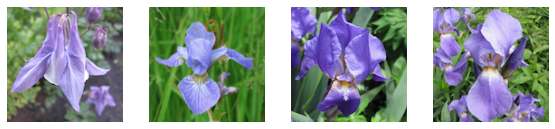

In [83]:
view_cluster(7)

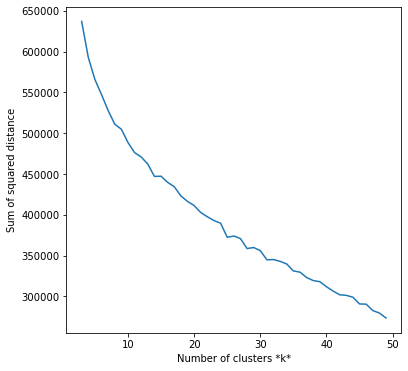

In [11]:
# this is just incase you want to see which value for k might be the best
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)

    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');